In [1]:
import os,sys

In [2]:
os.chdir("..")
!pwd

/global/home/users/lizhen/mydev/rsna2020


In [3]:
import io
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [4]:
!ls ./input

img  sample_submission.csv  test.csv  train.csv  train_pos.csv.gz


# train

In [5]:
df=pd.read_csv('input/train.csv')
traindf=df
df.shape

(1790594, 17)

In [6]:
df.head()

StudyInstanceUID SeriesInstanceUID SOPInstanceUID  pe_present_on_image  \
0     6897fa9de148      2bfbb7fd2e8b   c0f3cb036d06                    0   
1     6897fa9de148      2bfbb7fd2e8b   f57ffd3883b6                    0   
2     6897fa9de148      2bfbb7fd2e8b   41220fda34a3                    0   
3     6897fa9de148      2bfbb7fd2e8b   13b685b4b14f                    0   
4     6897fa9de148      2bfbb7fd2e8b   be0b7524ffb4                    0   

   negative_exam_for_pe  qa_motion  qa_contrast  flow_artifact  \
0                     0          0            0              0   
1                     0          0            0              0   
2                     0          0            0              0   
3                     0          0            0              0   
4                     0          0            0              0   

   rv_lv_ratio_gte_1  rv_lv_ratio_lt_1  leftsided_pe  chronic_pe  \
0                  0                 1             1           0   
1                  0                 1             1           0   
2                  0                 1             1           0   
3                  0                 1             1           0   
4                  0                 1             1           0   

   true_filling_defect_not_pe  rightsided_pe  acute_and_chronic_pe  \
0                           0              1                     0   
1                           0              1                     0   
2                           0              1                     0   
3                           0              1                     0   
4                           0              1                     0   

   central_pe  indeterminate  
0           0              0  
1           0              0  
2           0              0  
3           0              0  
4           0              0

In [7]:
df=df.drop(['pe_present_on_image','SeriesInstanceUID','SOPInstanceUID'],axis=1).drop_duplicates()
df.shape

(7279, 14)

In [40]:
df['StudyInstanceUID'].value_counts().value_counts()

1    7279
Name: StudyInstanceUID, dtype: int64

In [41]:
df=df.set_index('StudyInstanceUID')

In [42]:
target_columns=['acute_and_chronic_pe', 'leftsided_pe', 'rv_lv_ratio_lt_1',
       'rv_lv_ratio_gte_1', 'negative_exam_for_pe', 'chronic_pe', 'central_pe',
       'rightsided_pe', 'indeterminate']
len(target_columns) 

9

In [43]:
df.head()

negative_exam_for_pe  qa_motion  qa_contrast  flow_artifact  \
StudyInstanceUID                                                                
6897fa9de148                         0          0            0              0   
013358b540bb                         1          0            0              0   
0cee26703028                         0          0            0              0   
c28f3d01b14f                         0          0            0              0   
c8fbf1e08ac5                         1          0            0              0   

                  rv_lv_ratio_gte_1  rv_lv_ratio_lt_1  leftsided_pe  \
StudyInstanceUID                                                      
6897fa9de148                      0                 1             1   
013358b540bb                      0                 0             0   
0cee26703028                      0                 1             0   
c28f3d01b14f                      0                 1             1   
c8fbf1e08ac5                      0                 0             0   

                  chronic_pe  true_filling_defect_not_pe  rightsided_pe  \
StudyInstanceUID                                                          
6897fa9de148               0                           0              1   
013358b540bb               0                           0              0   
0cee26703028               1                           0              1   
c28f3d01b14f               0                           0              0   
c8fbf1e08ac5               0                           0              0   

                  acute_and_chronic_pe  central_pe  indeterminate  
StudyInstanceUID                                                   
6897fa9de148                         0           0              0  
013358b540bb                         0           0              0  
0cee26703028                         0           0              0  
c28f3d01b14f                         0           0              0  
c8fbf1e08ac5                         0           0              0

In [44]:
df['pe_on_at_least_one_image']=\
 (df['rightsided_pe']>0) | (df['leftsided_pe']>0) | (df['central_pe']>0)
df['pe_on_at_least_one_image']=df['pe_on_at_least_one_image'].astype(np.uint8)

In [45]:
df['pe_on_at_least_one_image'].mean()

0.3037505151806567

In [52]:
df['acute_pe']= (df['pe_on_at_least_one_image']>0) & (df['chronic_pe']==0) & (df['acute_and_chronic_pe']==0)
df['acute_pe']=df['acute_pe'].astype(np.uint8)

In [53]:
g=df.groupby(['chronic_pe','acute_and_chronic_pe', 'acute_pe'])[['acute_pe']].count()
g.columns=['count']
g=g.reset_index().sort_values('count')
g

chronic_pe  acute_and_chronic_pe  acute_pe  count
2           0                     1         0    145
3           1                     0         0    292
1           0                     0         1   1774
0           0                     0         0   5068

In [54]:
6685-4911

1774

In [64]:
exam_weights={
    'negative_exam_for_pe': 0.0736196319,
    'indeterminate':    0.09202453988,
    'chronic_pe': 0.1042944785,
    'acute_and_chronic_pe': 0.1042944785,
    'central_pe': 0.1877300613,
    'leftsided_pe': 0.06257668712,
    'rightsided_pe': 0.06257668712,
    'rv_lv_ratio_gte_1': 0.2346625767,
    'rv_lv_ratio_lt_1': 0.0782208589,
}

In [63]:
traindf.columns

Index(['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID',
       'pe_present_on_image', 'negative_exam_for_pe', 'qa_motion',
       'qa_contrast', 'flow_artifact', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
       'leftsided_pe', 'chronic_pe', 'true_filling_defect_not_pe',
       'rightsided_pe', 'acute_and_chronic_pe', 'central_pe', 'indeterminate'],
      dtype='object')

In [65]:
exam_weights

{'negative_exam_for_pe': 0.0736196319,
 'indeterminate': 0.09202453988,
 'chronic_pe': 0.1042944785,
 'acute_and_chronic_pe': 0.1042944785,
 'central_pe': 0.1877300613,
 'leftsided_pe': 0.06257668712,
 'rightsided_pe': 0.06257668712,
 'rv_lv_ratio_gte_1': 0.2346625767,
 'rv_lv_ratio_lt_1': 0.0782208589}

In [74]:
image_weights=traindf.groupby('StudyInstanceUID')['pe_present_on_image'].mean().to_dict()

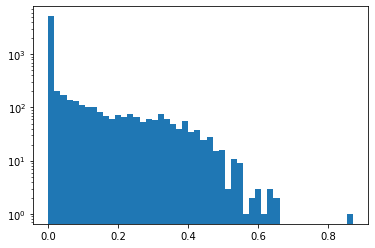

In [78]:
plt.hist(list(image_weights.values()),bins=50);
plt.yscale('log')

In [81]:
image_level_w=0.07361963

In [85]:
n_exam=traindf['StudyInstanceUID'].value_counts().shape[0]
n_exam

7279

In [87]:
n_rows=len(traindf)+n_exam*9
n_rows

1856105

In [95]:
traindf['pe_present_on_image'].sum()*image_level_w

7107.239080200001

In [96]:
a=n_exam*np.sum(list(exam_weights.values()))
b=(traindf.groupby(['StudyInstanceUID'])['pe_present_on_image'].sum()*image_level_w).sum()
total_weigths = (a+b)
a,b,total_weigths

(7278.99999941768, 7107.2390802, 14386.23907961768)

# img order

In [8]:
import gzip,pickle
def pickle_loadz(filepath):
    with gzip.open(filepath, 'rb') as f:
        return pickle.load(f) 

In [9]:
files = !ls /tmp/img/train
files[:2]

['0003b3d648eb.pklz', '000f7f114264.pklz']

In [17]:
from tqdm import tqdm
l=[]
for filename in tqdm(files):
    a=pickle_loadz("/tmp/img/train/"+filename)
    l+=([ ("/".join(u[0]).replace(".dcm",""),i/len(a), np.sum(u[3]))] for i,u in enumerate(a) ])
    #break

100%|██████████| 7279/7279 [47:16<00:00,  2.57it/s]  


In [18]:
len(l),len(traindf)

(1790594, 1790594)

In [29]:
l[0]

[('0003b3d648eb/d2b2960c2bbf/14605bcc564c', 0.0, 770)]

In [26]:
[list(u[1:]) for u in l[:3]]

[[], [], []]

In [30]:
adf=pd.DataFrame([list(u[0]) for u in l]).set_index(0)
adf.columns=['pos','area']
adf.head()

pos  area
0                                                     
0003b3d648eb/d2b2960c2bbf/14605bcc564c  0.000000   770
0003b3d648eb/d2b2960c2bbf/d0849d3b6507  0.004484   803
0003b3d648eb/d2b2960c2bbf/18928b724b69  0.008969   841
0003b3d648eb/d2b2960c2bbf/56bc011203f4  0.013453   871
0003b3d648eb/d2b2960c2bbf/24b933c4c518  0.017937   887

In [31]:
if 0:
    adf.to_csv("/global/home/users/lizhen/mydev/rsna2020/input/train_pos.csv.gz",compression='gzip')

In [32]:
traindf.index=traindf[['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID']].apply(lambda u: "/".join(u.values),axis=1)

In [103]:
traindf.loc[traindf['area']>8399*2,'area']=np.nan


In [44]:
m=adf['area'].to_dict()
traindf['area']=traindf.index.map(m)

In [45]:
x=traindf[traindf['pe_present_on_image']>0]
x.shape,(traindf['pe_present_on_image']>0).mean()

((96540, 19), 0.053915069524414806)

In [72]:
studyids=list(set(traindf['StudyInstanceUID']))
len(studyids),len(studyids)/24

(7279, 303.2916666666667)

In [156]:
from scipy.signal import savgol_filter
import statsmodels.api as sm

def smooth1(x):
    return  savgol_filter(x, 51, 2)

def smooth_data_np_convolve(arr):
    span= len(arr)//5
    if span>51: span=30
    if span<1: span=1
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_slices(traindf,studyid,smooth=smooth_data_np_convolve):
        a=traindf[traindf['StudyInstanceUID']==studyid].sort_values('pos')
        a.loc[a['area']>8399*2,'area']=np.nan
        a['area']=a['area']/a['area'].max()
        a['area']=a['area'].fillna(method='ffill').fillna(method='bfill')
        a['area']=smooth(a['area'].values)
        return a['pos'].values,a['area'].values
        
def save_plot(k, s, smooth=smooth_data_np_convolve, show=False):
    f=plt.figure(figsize=(16*2,24))
    for idx,studyid in enumerate(s):
        plt.subplot(6,4*2,idx+1)
        a=traindf[traindf['StudyInstanceUID']==studyid].sort_values('pos')
        a['area']=a['area']/a['area'].max()
        a['area']=a['area'].fillna(method='ffill').fillna(method='bfill')
        a['area']=smooth(a['area'].values)
        plt.scatter(a['pos'],a['pe_present_on_image'],s=10);
        plt.scatter(a['pos'],a['area'],s=10)
        plt.axis('off')
        plt.title(studyid)
    if not show:
        f.savefig("/tmp/pdf_{}.pdf".format(k), bbox_inches='tight')
        f.clear()
    else:
        plt.show()

In [158]:
d={}
for s in tqdm(studyids):
    d[s]=smooth_slices(traindf,s)
print(len(d))
for k,v in d.items():
    print(k,v)
    break

100%|██████████| 7279/7279 [15:18<00:00,  7.92it/s]


7279
5a649181c295 (array([0.        , 0.00364964, 0.00729927, 0.01094891, 0.01459854,
       0.01824818, 0.02189781, 0.02554745, 0.02919708, 0.03284672,
       0.03649635, 0.04014599, 0.04379562, 0.04744526, 0.05109489,
       0.05474453, 0.05839416, 0.0620438 , 0.06569343, 0.06934307,
       0.0729927 , 0.07664234, 0.08029197, 0.08394161, 0.08759124,
       0.09124088, 0.09489051, 0.09854015, 0.10218978, 0.10583942,
       0.10948905, 0.11313869, 0.11678832, 0.12043796, 0.12408759,
       0.12773723, 0.13138686, 0.1350365 , 0.13868613, 0.14233577,
       0.1459854 , 0.14963504, 0.15328467, 0.15693431, 0.16058394,
       0.16423358, 0.16788321, 0.17153285, 0.17518248, 0.17883212,
       0.18248175, 0.18613139, 0.18978102, 0.19343066, 0.19708029,
       0.20072993, 0.20437956, 0.2080292 , 0.21167883, 0.21532847,
       0.2189781 , 0.22262774, 0.22627737, 0.22992701, 0.23357664,
       0.23722628, 0.24087591, 0.24452555, 0.24817518, 0.25182482,
       0.25547445, 0.25912409, 0.26277372, 

In [159]:
with open("/tmp/train_smooth_mask_curve.pkl",'wb') as f:
    pickle.dump(d,f)

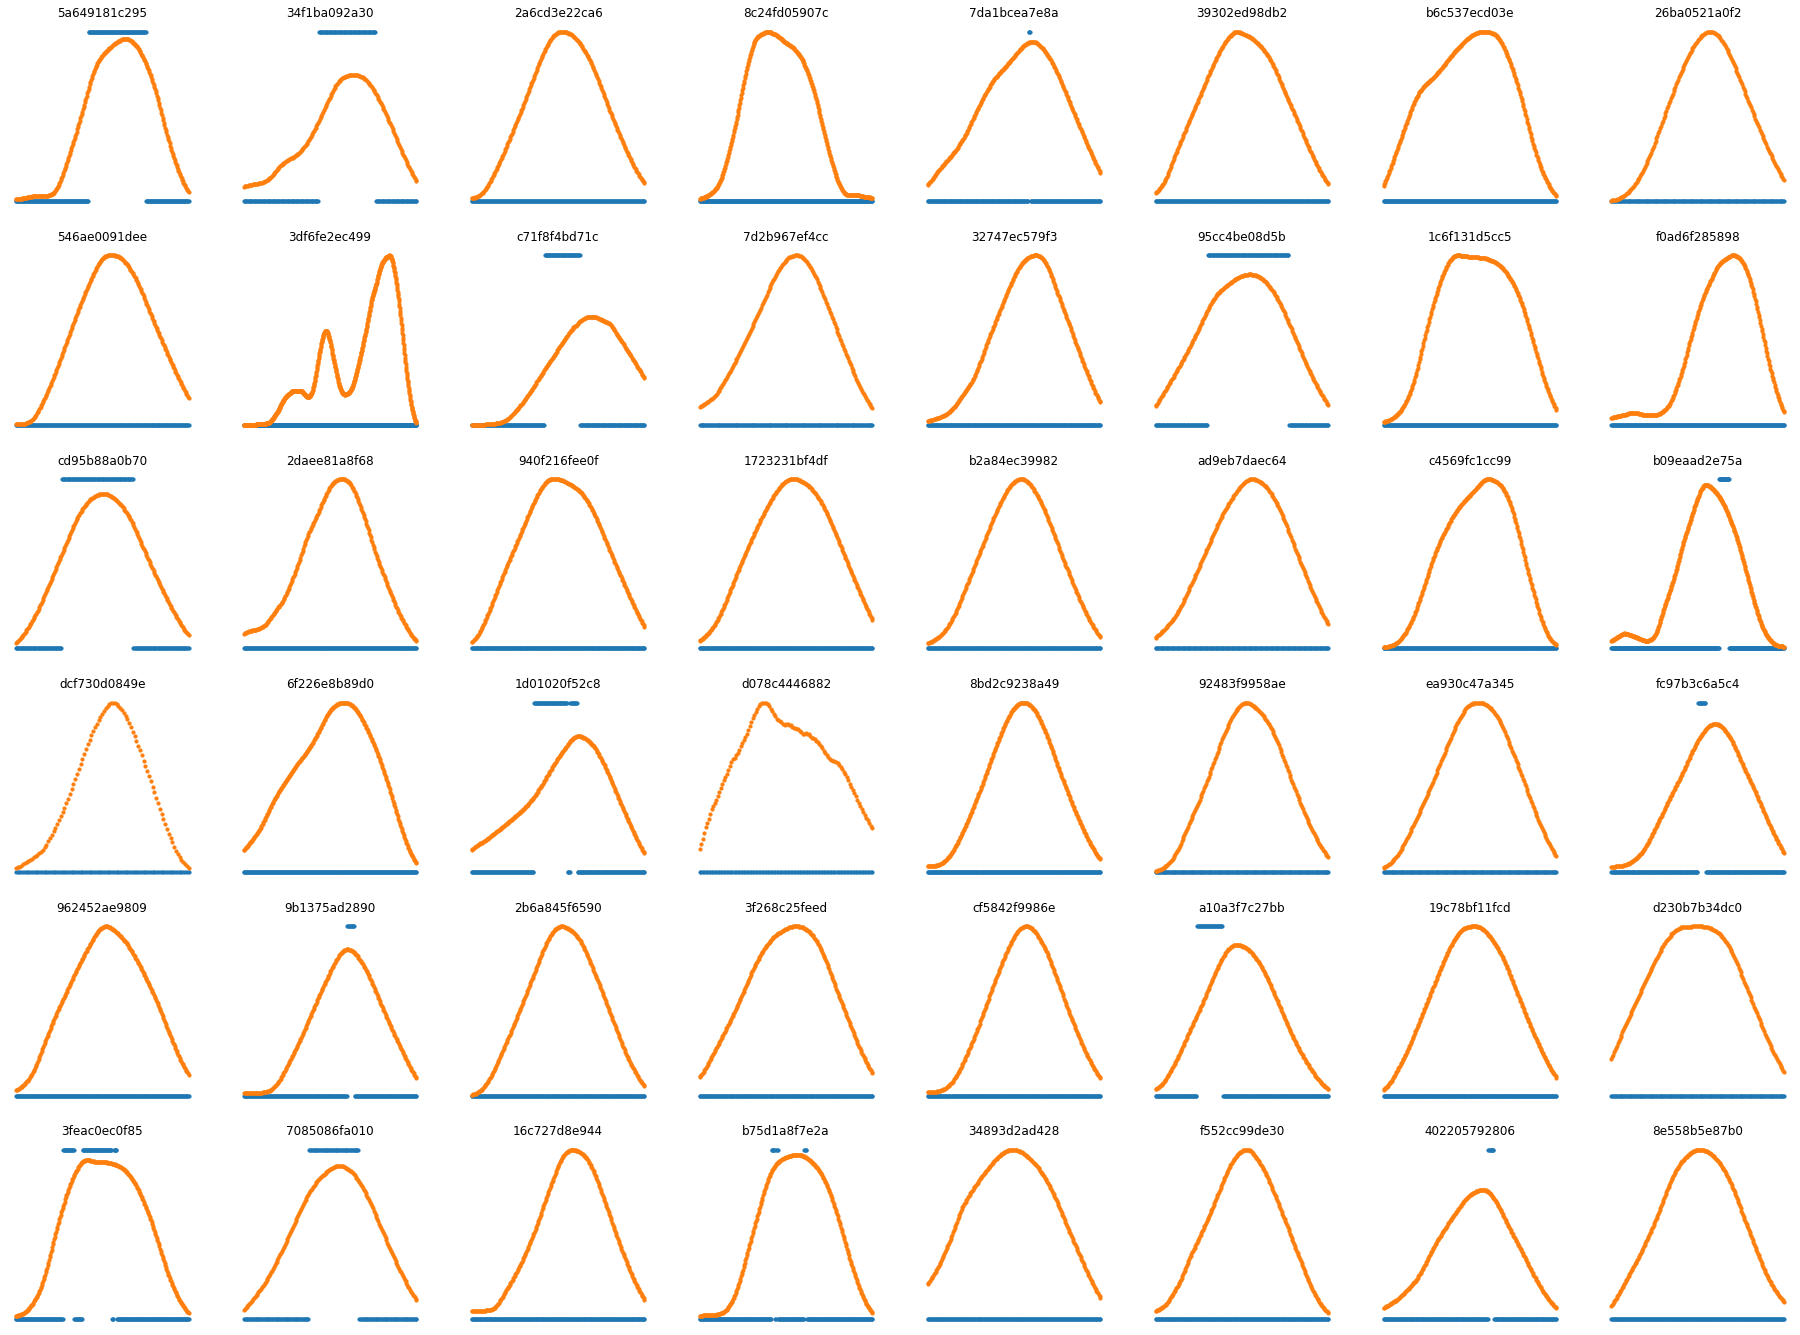

In [149]:
save_plot(0,studyids[0:0+48],True)

In [154]:
for i in tqdm(range(0,len(studyids),48)):
    s=studyids[i:i+48]
    save_plot(i,s);

 13%|█▎        | 20/152 [04:00<26:15, 11.93s/it]/global/scratch/lizhen/osic2020/osicenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
100%|██████████| 152/152 [29:41<00:00, 11.72s/it]


<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

<Figure size 2304x1728 with 0 Axes>

In [68]:
297/210

1.4142857142857144

In [33]:
m=adf['pos'].to_dict()
traindf['pos']=traindf.index.map(m)

In [34]:
x=traindf[traindf['pe_present_on_image']>0]

In [35]:
x.shape,(traindf['pe_present_on_image']>0).mean()

((96540, 18), 0.053915069524414806)

In [57]:
x.sort_values('pos').head(10)

StudyInstanceUID SeriesInstanceUID  \
baa23ea7f9c3/ffcfb2c00799/10318cbf0ac9     baa23ea7f9c3      ffcfb2c00799   
3bc92a9daeb9/51a2fc604368/dfac11732ea7     3bc92a9daeb9      51a2fc604368   
3bc92a9daeb9/51a2fc604368/da3d7281623a     3bc92a9daeb9      51a2fc604368   
3bc92a9daeb9/51a2fc604368/a7e459a774c1     3bc92a9daeb9      51a2fc604368   
3bc92a9daeb9/51a2fc604368/2c9862f0a718     3bc92a9daeb9      51a2fc604368   
a3d13539e406/f19c2ba00228/fbb8f37038db     a3d13539e406      f19c2ba00228   
3bc92a9daeb9/51a2fc604368/a8b00186cdc2     3bc92a9daeb9      51a2fc604368   
a3d13539e406/f19c2ba00228/4372d9ea6cc1     a3d13539e406      f19c2ba00228   
57756f1d5e74/1b833d7d83a0/69d6174f6014     57756f1d5e74      1b833d7d83a0   
57756f1d5e74/1b833d7d83a0/cad60793b3df     57756f1d5e74      1b833d7d83a0   

                                       SOPInstanceUID  pe_present_on_image  \
baa23ea7f9c3/ffcfb2c00799/10318cbf0ac9   10318cbf0ac9                    1   
3bc92a9daeb9/51a2fc604368/dfac11732ea7   dfac11732ea7                    1   
3bc92a9daeb9/51a2fc604368/da3d7281623a   da3d7281623a                    1   
3bc92a9daeb9/51a2fc604368/a7e459a774c1   a7e459a774c1                    1   
3bc92a9daeb9/51a2fc604368/2c9862f0a718   2c9862f0a718                    1   
a3d13539e406/f19c2ba00228/fbb8f37038db   fbb8f37038db                    1   
3bc92a9daeb9/51a2fc604368/a8b00186cdc2   a8b00186cdc2                    1   
a3d13539e406/f19c2ba00228/4372d9ea6cc1   4372d9ea6cc1                    1   
57756f1d5e74/1b833d7d83a0/69d6174f6014   69d6174f6014                    1   
57756f1d5e74/1b833d7d83a0/cad60793b3df   cad60793b3df                    1   

                                        negative_exam_for_pe  qa_motion  \
baa23ea7f9c3/ffcfb2c00799/10318cbf0ac9                     0          0   
3bc92a9daeb9/51a2fc604368/dfac11732ea7                     0          0   
3bc92a9daeb9/51a2fc604368/da3d7281623a                     0          0   
3bc92a9daeb9/51a2fc604368/a7e459a774c1                     0          0   
3bc92a9daeb9/51a2fc604368/2c9862f0a718                     0          0   
a3d13539e406/f19c2ba00228/fbb8f37038db                     0          0   
3bc92a9daeb9/51a2fc604368/a8b00186cdc2                     0          0   
a3d13539e406/f19c2ba00228/4372d9ea6cc1                     0          0   
57756f1d5e74/1b833d7d83a0/69d6174f6014                     0          0   
57756f1d5e74/1b833d7d83a0/cad60793b3df                     0          0   

                                        qa_contrast  flow_artifact  \
baa23ea7f9c3/ffcfb2c00799/10318cbf0ac9            0              0   
3bc92a9daeb9/51a2fc604368/dfac11732ea7            0              0   
3bc92a9daeb9/51a2fc604368/da3d7281623a            0              0   
3bc92a9daeb9/51a2fc604368/a7e459a774c1            0              0   
3bc92a9daeb9/51a2fc604368/2c9862f0a718            0              0   
a3d13539e406/f19c2ba00228/fbb8f37038db            0              0   
3bc92a9daeb9/51a2fc604368/a8b00186cdc2            0              0   
a3d13539e406/f19c2ba00228/4372d9ea6cc1            0              0   
57756f1d5e74/1b833d7d83a0/69d6174f6014            0              0   
57756f1d5e74/1b833d7d83a0/cad60793b3df            0              0   

                                        rv_lv_ratio_gte_1  rv_lv_ratio_lt_1  \
baa23ea7f9c3/ffcfb2c00799/10318cbf0ac9                  1                 0   
3bc92a9daeb9/51a2fc604368/dfac11732ea7                  1                 0   
3bc92a9daeb9/51a2fc604368/da3d7281623a                  1                 0   
3bc92a9daeb9/51a2fc604368/a7e459a774c1                  1                 0   
3bc92a9daeb9/51a2fc604368/2c9862f0a718                  1                 0   
a3d13539e406/f19c2ba00228/fbb8f37038db                  0                 1   
3bc92a9daeb9/51a2fc604368/a8b00186cdc2                  1                 0   
a3d13539e406/f19c2ba00228/4372d9ea6cc1                  0                 1   
57756f1d5e74/1b833d7d83a

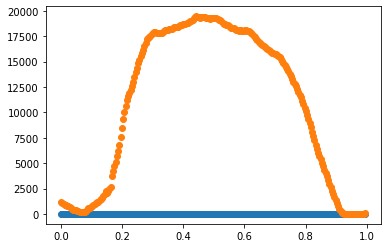

In [96]:
if 1:
    a=traindf[traindf['StudyInstanceUID']=='24e70378db40'].sort_values('pos')
    plt.scatter(a['pos'],a['pe_present_on_image'])
    plt.scatter(a['pos'],a['area'])

In [38]:
x['pos'].describe()

count    96540.000000
mean         0.514499
std          0.134480
min          0.000000
25%          0.419188
50%          0.514894
75%          0.614108
max          0.998505
Name: pos, dtype: float64

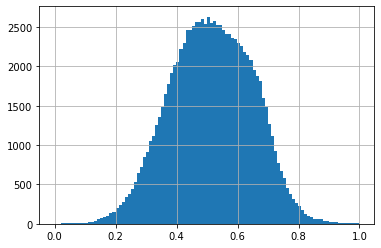

In [39]:
x['pos'].hist(bins=100);

<AxesSubplot:>

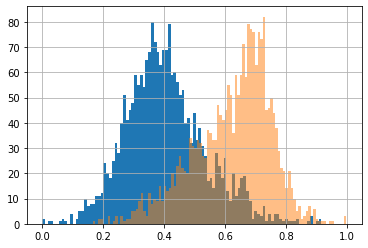

In [40]:
x.groupby('StudyInstanceUID')['pos'].min().hist(bins=100)
x.groupby('StudyInstanceUID')['pos'].max().hist(bins=100,alpha=.5)

0.03482587064676617

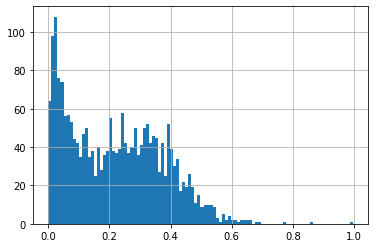

In [41]:
a=x.groupby('StudyInstanceUID')['pos'].max()-x.groupby('StudyInstanceUID')['pos'].min()
a.hist(bins=100,alpha=1)
(a>0.5).mean()

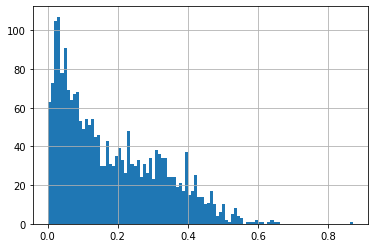

In [42]:
a=traindf.groupby(['StudyInstanceUID'])['pe_present_on_image'].mean()
(a[a>0]).hist(bins=100);

In [43]:
traindf.columns

Index(['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID',
       'pe_present_on_image', 'negative_exam_for_pe', 'qa_motion',
       'qa_contrast', 'flow_artifact', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
       'leftsided_pe', 'chronic_pe', 'true_filling_defect_not_pe',
       'rightsided_pe', 'acute_and_chronic_pe', 'central_pe', 'indeterminate',
       'pos'],
      dtype='object')

In [121]:
traindf.head()

StudyInstanceUID SeriesInstanceUID SOPInstanceUID  pe_present_on_image  \
0     6897fa9de148      2bfbb7fd2e8b   c0f3cb036d06                    0   
1     6897fa9de148      2bfbb7fd2e8b   f57ffd3883b6                    0   
2     6897fa9de148      2bfbb7fd2e8b   41220fda34a3                    0   
3     6897fa9de148      2bfbb7fd2e8b   13b685b4b14f                    0   
4     6897fa9de148      2bfbb7fd2e8b   be0b7524ffb4                    0   

   negative_exam_for_pe  qa_motion  qa_contrast  flow_artifact  \
0                     0          0            0              0   
1                     0          0            0              0   
2                     0          0            0              0   
3                     0          0            0              0   
4                     0          0            0              0   

   rv_lv_ratio_gte_1  rv_lv_ratio_lt_1  leftsided_pe  chronic_pe  \
0                  0                 1             1           0   
1                  0                 1             1           0   
2                  0                 1             1           0   
3                  0                 1             1           0   
4                  0                 1             1           0   

   true_filling_defect_not_pe  rightsided_pe  acute_and_chronic_pe  \
0                           0              1                     0   
1                           0              1                     0   
2                           0              1                     0   
3                           0              1                     0   
4                           0              1                     0   

   central_pe  indeterminate  
0           0              0  
1           0              0  
2           0              0  
3           0              0  
4           0              0